<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Let's download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2021-07-15 19:09:19--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.001s  

2021-07-15 19:09:19 (16.0 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Let's plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: | ^C
failed with initial frozen solve. Retrying with flexible solve.

CondaError: KeyboardInterrupt



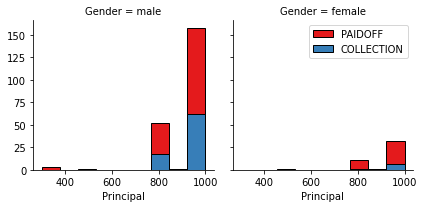

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

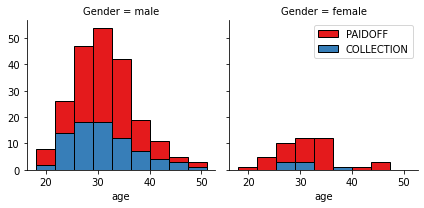

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Let's look at the day of the week people get the loan 

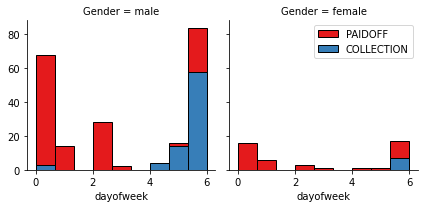

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head(10)


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1
5,7,7,PAIDOFF,1000,30,2016-09-09,2016-10-08,36,college,male,4,1
6,8,8,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,male,4,1
7,9,9,PAIDOFF,800,15,2016-09-10,2016-09-24,26,college,male,5,1
8,10,10,PAIDOFF,300,7,2016-09-10,2016-09-16,29,college,male,5,1
9,11,11,PAIDOFF,1000,15,2016-09-10,2016-10-09,39,High School or Below,male,5,1


## Convert Categorical features to numerical values

Let's look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature = Feature.drop(['Master or Above'], axis = 1,inplace=False)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

In [20]:
type(X)

numpy.ndarray

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# Train Test Split

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [22]:
from sklearn.neighbors import KNeighborsClassifier

Start with 4 nearest neighbors and make prediction

In [23]:
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat = neigh.predict(X_test)

Find accuracy for the prediction

In [24]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.8152173913043478
Test set Accuracy:  0.6857142857142857


Now similar to what we learned in the course we can find the best k (# of nearest neighbors) based on the accuracy metric

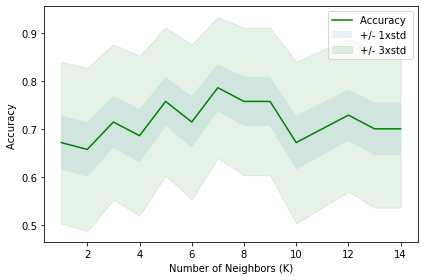

In [25]:
Ks = 15
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

# result shows k=7 is prob the best k for KNN method

In [26]:
print('The best accuracy is',mean_acc.max(),'when K=',mean_acc.argmax()+1)

The best accuracy is 0.7857142857142857 when K= 7


Now we can train our KNN again with K = 7

In [29]:
k=7

final_knn = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
final_yhat = final_knn.predict(X_test)

print('Train set accuracy:', metrics.accuracy_score(y_train, final_knn.predict(X_train)))
print('Test set accuracy:', metrics.accuracy_score(y_test, final_yhat))

Train set accuracy: 0.8079710144927537
Test set accuracy: 0.7857142857142857


In [41]:
y_test

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF'], dtype=object)

Finally, we define a new matrix for storing the Jaccard and F1 scores for all models

In [49]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

summary = {}

summary['knn_jaccard'] = jaccard_score(y_test, final_yhat, pos_label="PAIDOFF")
summary['knn_f1_score'] = f1_score(y_test, final_yhat, average='weighted')
summary

{'knn_jaccard': 0.765625, 'knn_f1_score': 0.7766540244416351}

# Decision Tree

In [31]:
from sklearn.tree import DecisionTreeClassifier

Similar to KNN, we need to find the best depth based on model accuracy

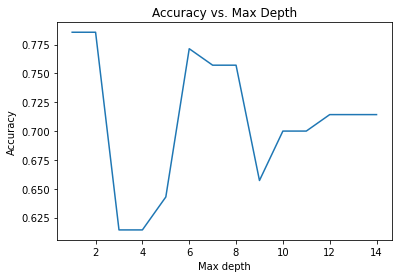

In [32]:
k=15
mean_acc = np.zeros((k-1))

for n in range(1,k):
    
    test_tree= DecisionTreeClassifier(criterion="entropy", max_depth=n).fit(X_train, y_train)
    yhat=test_tree.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test,yhat)
    

# Plotting depth vs. accuracy
plt.plot(range(1,k), mean_acc)
plt.xlabel("Max depth")
plt.ylabel("Accuracy")
plt.title('Accuracy vs. Max Depth')
plt.show()

In [33]:
print('The best accuracy is when max_depth is', mean_acc.argmax()+1)

The best accuracy is when max_depth is 1


Since max depth of 1 might lead to underfitting, we can get the next best accuracy with max depth of 6

In [34]:
data_tree = DecisionTreeClassifier(criterion="entropy",max_depth=6)
data_tree.fit(X_train,y_train)
tree_yhat = data_tree.predict(X_test)

print('train set accuracy:', metrics.accuracy_score(y_train, data_tree.predict(X_train)))
print('test set accuracy:', metrics.accuracy_score(y_test, tree_yhat))

train set accuracy: 0.7753623188405797
test set accuracy: 0.7714285714285715


We can now visualize the tree

In [36]:
!pip install graphviz
!pip install pydotplus

from sklearn import tree
from IPython.display import Image  
import graphviz 
import pydotplus

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 278 kB 21.8 MB/s eta 0:00:01
  Created wheel for pydotplus: 

Plot the decision tree

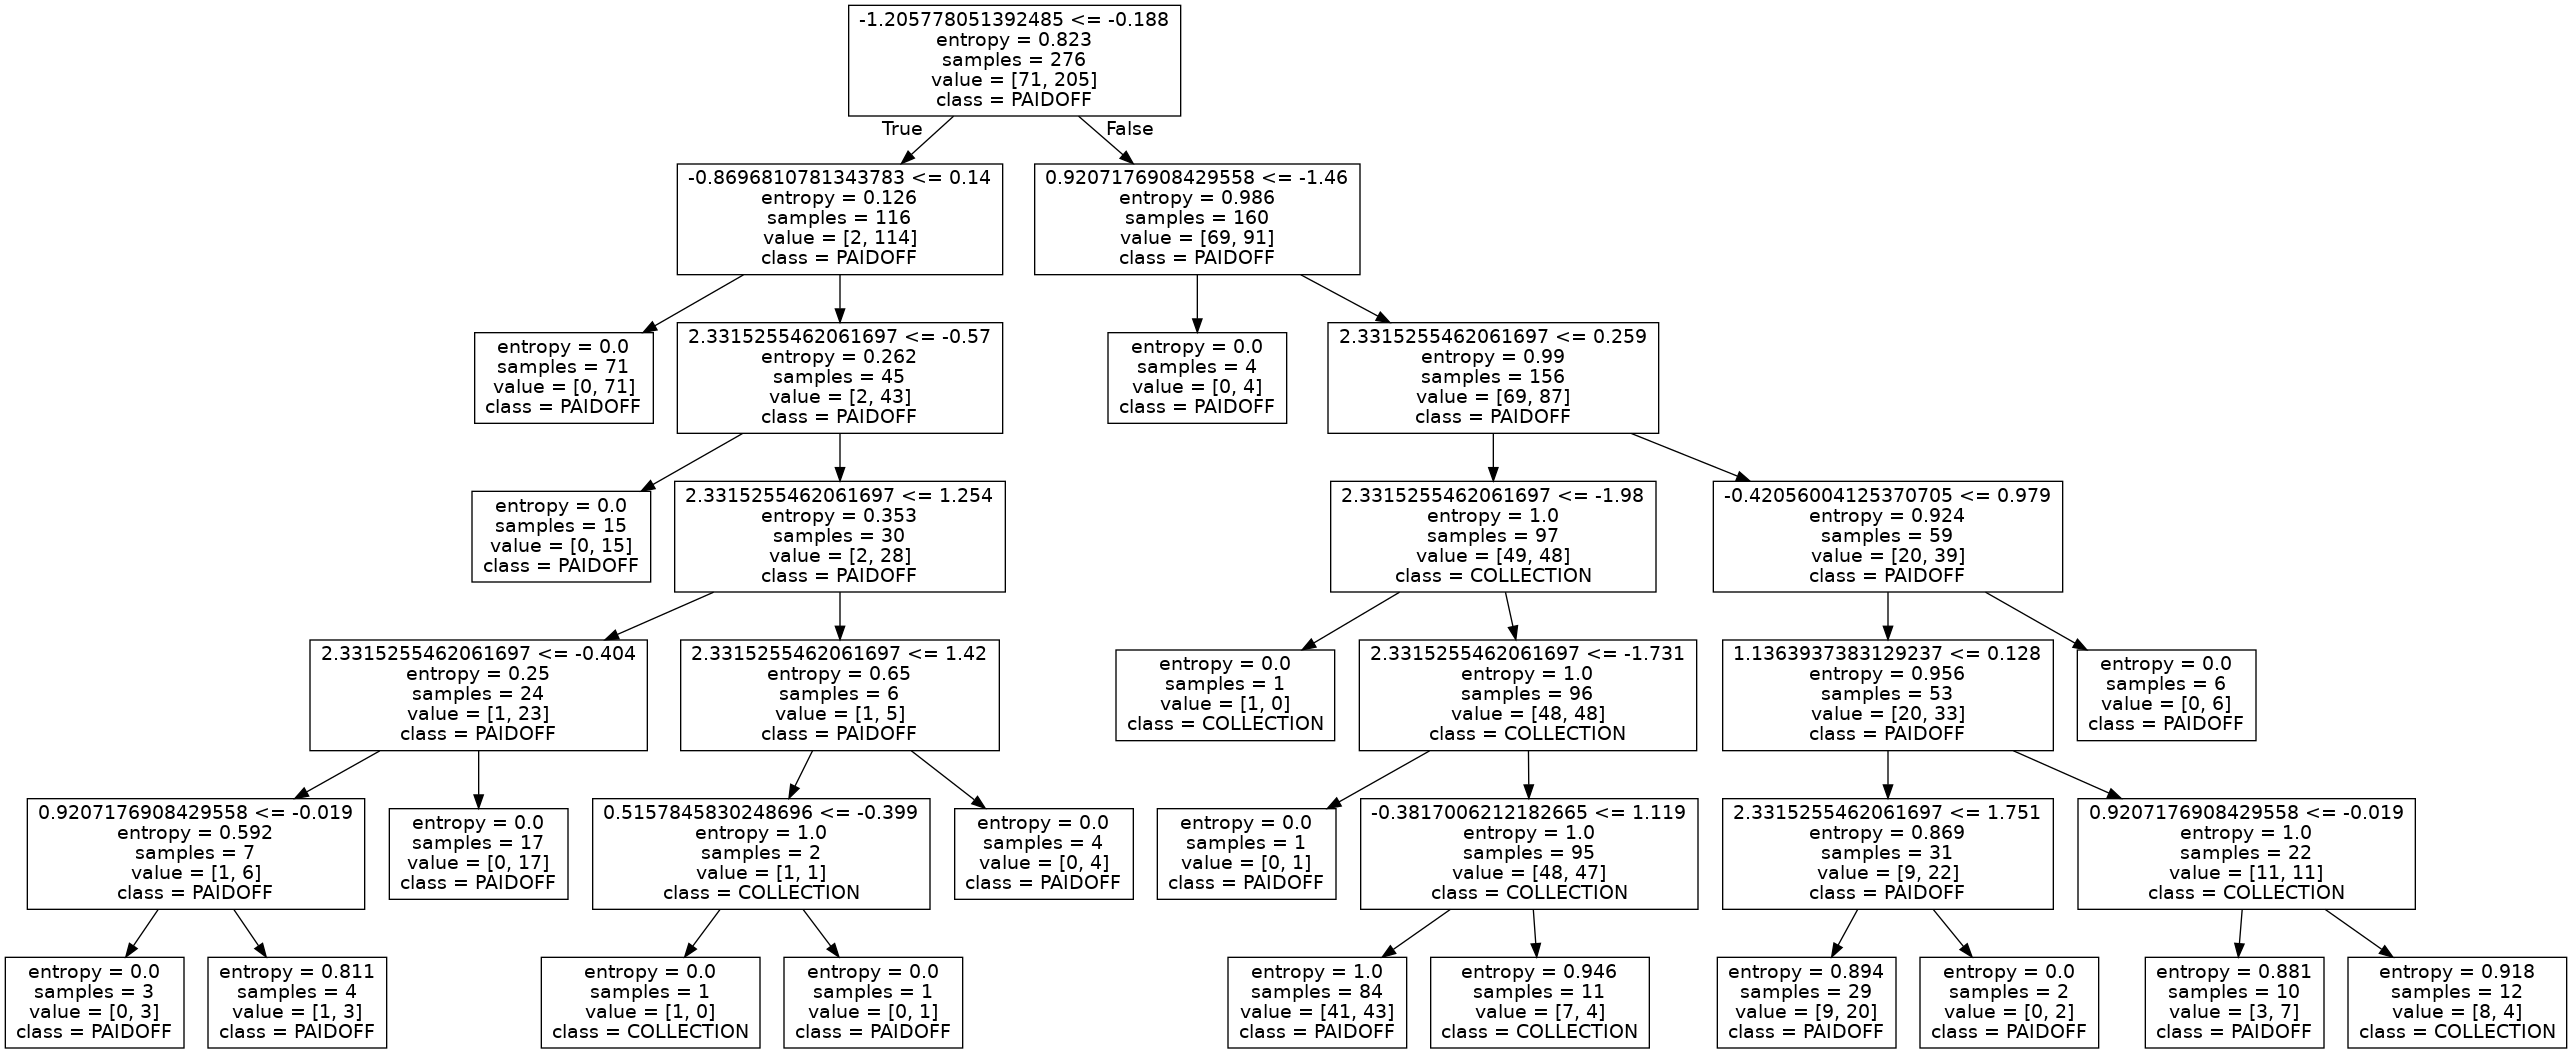

In [61]:
feature_names = X[0,:]

dot_data = tree.export_graphviz(data_tree, out_file=None, 
                     feature_names=feature_names,  
                     class_names= np.unique(y_train))

graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())

Add the Jaccard and F1 scores for decision tree method to the summary matrix

In [62]:
summary['tree_jaccard'] = jaccard_score(y_test, tree_yhat, pos_label="PAIDOFF")
summary['tree_f1_score'] = f1_score(y_test, tree_yhat, average='weighted')
summary

{'knn_jaccard': 0.765625,
 'knn_f1_score': 0.7766540244416351,
 'tree_jaccard': 0.7681159420289855,
 'tree_f1_score': 0.7064793130366899}

# Support Vector Machine

In [65]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 
svm_yhat = clf.predict(X_test)


print('train set accuracy:', metrics.accuracy_score(y_train, clf.predict(X_train)))
print('test set accuracy:', metrics.accuracy_score(y_test, svm_yhat)) 

train set accuracy: 0.782608695652174
test set accuracy: 0.7428571428571429


Add the Jaccard and F1 scores for svm method to the summary matrix

In [66]:
summary['svm_jaccard'] = jaccard_score(y_test, svm_yhat, pos_label="PAIDOFF")
summary['svm_f1_score'] = f1_score(y_test, svm_yhat, average='weighted')
summary

{'knn_jaccard': 0.765625,
 'knn_f1_score': 0.7766540244416351,
 'tree_jaccard': 0.7681159420289855,
 'tree_f1_score': 0.7064793130366899,
 'svm_jaccard': 0.7272727272727273,
 'svm_f1_score': 0.7275882012724117}

# Logistic Regression

In [73]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(C=0.01, solver='saga').fit(X_train,y_train)
lr_yhat = LR.predict(X_test)

lr_yhat_prob = LR.predict_proba(X_test)

Add the Jaccard and F1 scores for logistic regression method to the summary matrix

In [76]:
from sklearn.metrics import log_loss
summary['lr_jaccard'] = jaccard_score(y_test, lr_yhat, pos_label="PAIDOFF")
summary['lr_f1_score'] = f1_score(y_test, lr_yhat, average='weighted')
summary['lr_logloss']= log_loss(y_test, lr_yhat_prob)

summary

{'knn_jaccard': 0.765625,
 'knn_f1_score': 0.7766540244416351,
 'tree_jaccard': 0.7681159420289855,
 'tree_f1_score': 0.7064793130366899,
 'svm_jaccard': 0.7272727272727273,
 'svm_f1_score': 0.7275882012724117,
 'lr_jaccard': 0.7857142857142857,
 'lr_f1_score': 0.6914285714285714,
 'lr_logloss': 0.49203284137074804}

Finally, we can make a table with our results

In [78]:
Jaccard_score_row = [summary['knn_jaccard'], summary['tree_jaccard'], summary['svm_jaccard'], summary['lr_jaccard']]

f1_score_row = [summary['knn_f1_score'], summary['tree_f1_score'], summary['svm_f1_score'], summary['lr_f1_score']]

log_loss_row = ['NA','NA','NA', summary['lr_logloss']]

df = {'Algorithm': ['KNN','Decision-tree', 'SVM','Logistic-regression'], \
'Jaccard': Jaccard_score_row, 'F1-score': f1_score_row, 'LogLoss': log_loss_row}

summary_table = pd.DataFrame(data=df, columns=['Algorithm', 'Jaccard', 'F1-score', 'LogLoss'], index=None)
summary_table

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.765625,0.776654,NA
1,Decision-tree,0.768116,0.706479,NA
2,SVM,0.727273,0.727588,NA
3,Logistic-regression,0.785714,0.691429,0.492033


# Model Evaluation using Test set

First, download and load the test set:

In [79]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-07-15 20:12:39--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-07-15 20:12:40 (84.4 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [83]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### Perform the same preprocessing steps on the test data

In [84]:
# convert make female to 0 and 1
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

# convert to date to time object
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

# convert to day of week 
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

# introduce a weekend column
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

# one hot encoding
Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature = Feature.drop(['Master or Above'], axis = 1,inplace=False)
Feature.head()
X_test_set = Feature
X_test_set[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [85]:
y_test_set = test_df['loan_status'].values
y_test_set[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [86]:
X_test_set= preprocessing.StandardScaler().fit(X_test_set).transform(X_test_set)
X_test_set[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

### KNN Performance on Test Data

In [104]:
knn_test_yhat= final_knn.predict(X_test)

test_summary = {}
test_summary['knn_jaccard'] = jaccard_score(y_test, knn_test_yhat, pos_label="PAIDOFF")
test_summary['knn_f1_score'] = f1_score(y_test, knn_test_yhat, average='weighted')
test_summary

{'knn_jaccard': 0.765625, 'knn_f1_score': 0.7766540244416351}

### Decision Tree Performance on Test Data

In [105]:
dt_yhat = data_tree.predict(X_test)

test_summary['tree_jaccard'] = jaccard_score(y_test, dt_yhat, pos_label="PAIDOFF")
test_summary['tree_f1_score'] = f1_score(y_test, dt_yhat, average='weighted')
test_summary

{'knn_jaccard': 0.765625,
 'knn_f1_score': 0.7766540244416351,
 'tree_jaccard': 0.7681159420289855,
 'tree_f1_score': 0.7064793130366899}

### SVM Performance on Test Data

In [106]:
svm_yhat= clf.predict(X_test)

test_summary['svm_jaccard'] = jaccard_score(y_test, svm_yhat, pos_label="PAIDOFF")
test_summary['svm_f1_score'] = f1_score(y_test, svm_yhat, average='weighted')
test_summary

{'knn_jaccard': 0.765625,
 'knn_f1_score': 0.7766540244416351,
 'tree_jaccard': 0.7681159420289855,
 'tree_f1_score': 0.7064793130366899,
 'svm_jaccard': 0.7272727272727273,
 'svm_f1_score': 0.7275882012724117}

### Logistic Regression Performance on Test Data

In [107]:
lr_yhat = LR.predict(X_test)
lr_yhat_prob = LR.predict_proba(X_test)

test_summary['lr_jaccard'] = jaccard_score(y_test, lr_yhat, pos_label="PAIDOFF")
test_summary['lr_f1_score'] = f1_score(y_test, lr_yhat, average='weighted')
test_summary['lr_logloss'] = log_loss(y_test, lr_yhat_prob)

test_summary

{'knn_jaccard': 0.765625,
 'knn_f1_score': 0.7766540244416351,
 'tree_jaccard': 0.7681159420289855,
 'tree_f1_score': 0.7064793130366899,
 'svm_jaccard': 0.7272727272727273,
 'svm_f1_score': 0.7275882012724117,
 'lr_jaccard': 0.7857142857142857,
 'lr_f1_score': 0.6914285714285714,
 'lr_logloss': 0.49203284137074804}

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.76    | 0.77     | NA      |
| Decision Tree      | 0.76    | 0.70     | NA      |
| SVM                | 0.72    | 0.72     | NA      |
| LogisticRegression | 0.78    | 0.69     | 0.49    |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>